In [1]:
from quantumml.rest import MWRester
from pymatgen import Structure
import json
from quantumml.descriptors import get_soap
from quantumml.mlModels import MLModel

# Machine Learning
Below is an example of using the pretrained model on unseen data from materialsproject

In [2]:
from pymatgen import MPRester
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
import os
from pymatgen.io.vasp import inputs
os.mkdir('mldir')
os.chdir('mldir')
a = MPRester('7JGUQgNZyOTTp8Tc')
entries = a.query('Cd-Te',properties = ['structure','formation_energy_per_atom'])
#entries = a.query('Cd-Te',properties = ['formation_energy_per_atom'])
formation_e_actual=[]
i= 0 
for d in entries:
    d['structure'].to(fmt='poscar',filename=str(i)+'.poscar')
    formation_e_actual.append(d['formation_energy_per_atom'])
    i = i +1 

In [3]:
formation_e_predict=[]
model= MLModel.get_ml_model('Cd-Te')
for i in range(0,10):
    formation_e_predict.append(model.predict(get_soap('./'+str(i)+'.poscar',normalize = False))[0])
for pred, act in zip(formation_e_predict, formation_e_actual):
    print(f'Prediction = {pred}\t Acutal = {act}\t')

Prediction = -0.14410193900944912	 Acutal = -0.2763495549999999	
Prediction = -0.13000097198399885	 Acutal = -0.34565693333333325	
Prediction = -0.11422573250777979	 Acutal = 0.027823344999999833	
Prediction = -0.10077391664659907	 Acutal = -0.4523537375000002	
Prediction = -0.12349066042150114	 Acutal = -0.4582981199999998	
Prediction = -0.15577583518796478	 Acutal = -0.0942426300000001	
Prediction = -0.13374894386785285	 Acutal = -0.27434149250000006	
Prediction = -0.10026401866853074	 Acutal = -0.4496796275000001	
Prediction = -0.14057497942726105	 Acutal = 0.08023137499999988	
Prediction = -0.14409587563760562	 Acutal = -0.28503561499999996	


The above example is for illistration purposes only. I believe a large portion of the error is due to differences in formation energy calculations. An additional change that will need to be implemented is a way to no the descriptor parameters for a specific model.

# How the ML models are made

In [4]:
%matplotlib inline
import os
import multiprocessing

import scipy
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV as CV

from pymatgen.io.vasp import Poscar
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view
from sklearn.svm import SVR

In [5]:
#from thundersvm import SVR # much faster with GPU support

def tw(iterable, **kwargs):
    "Add a progress bar using tqdm if available"
    try:
        import tqdm
        tqdm.tqdm._instances.clear()
        # clear existing instances
    except AttributeError:
        pass
    try:
        return tqdm.tqdm_notebook(iterable, **kwargs)
    except NameError:
        return iterable  # could not import tqdm

# Set up (basic settings here)
CdTe dataset is available at https://materialsweb.org/docs . click on the CdTe tab

Big picture:
1) Parse structure and energy files

2) Generate representations

3) Optimize and fit models with support vector regression/

In [8]:
n_cores = 3  # number of cores to use for multiprocessing.
### uncomment the following line to use all available cores
#n_cores = multiprocessing.cpu_count()

In [9]:
!pwd

/home/jason/dev/qml/quantumml/mldir


In [10]:
# directory of POSCARs and energy files
working_directory = '.'
directory_path = "/home/jason/dev/molssi/CdTe_Archive" #Path to data

structure_ext = 'poscar'  #file extension names
target_ext = 'energy'

element_list = ['Cd', 'Te']  # list of elements to consider

# File Parsing

In [11]:
def process_entry(args):
    """parse files"""
    entry_name, element_list, directory_path, structure_ext, target_ext = args
    target_file = '{}/{}.{}'.format(directory_path,
                                    entry_name,
                                    target_ext)
    with open(target_file) as f:
        lines = f.read().splitlines()
    local_energies = [float(line) for line in lines]
    # This dataset has per-atom energies but we won't use them
    energy = np.sum(local_energies)
    
    structure_file = '{}/{}.{}'.format(directory_path,
                                       entry_name,
                                       structure_ext)
    structure = Poscar.from_file(structure_file).structure
    entry_data = [len(structure), energy]
    for element in element_list:
        element_percent = structure.composition.get_atomic_fraction(element)
        entry_data.append(element_percent)
    return structure, entry_data

file_stems = [os.path.splitext(f)[0]
              for f in os.listdir(directory_path) 
              if structure_ext in f]
# check the working directory for files matching the ext

columns = ['Size', 'Total Energy'] + element_list  # pandas header

# prepare zipped arguments for parallel parsing
zipped_args = [(f, element_list, directory_path, structure_ext, target_ext)
               for f in file_stems]
parsed_data = list(tw(multiprocessing.Pool(n_cores).imap(process_entry,
                                                         zipped_args),
                      total=len(zipped_args)))

In [12]:
# unpack parallel parsing results
structure_list, table_data = zip(*parsed_data)
structures = {k: v for k, v in zip(file_stems, structure_list)}
df = pd.DataFrame(columns=columns, data=table_data, index=file_stems)

# Get Reference Energies
While learning on total energies is desirable in some scenarios, we often want to predict formation energy per atom to compare relative stabilities. Here, we normalize the total energy of each structure by the reference energies. These are the lowest-energy elemental structures in the dataset.

In [13]:
reference_energies = {}
for element in element_list:
    pure_entries = df[df[element] == 1.0]
    pure_entry_energies = pure_entries['Total Energy'].values
    pure_entry_energies /= pure_entries['Size'].values
    minimum_energy = np.min(pure_entry_energies)
    reference_energies[element] = minimum_energy
reference_energies

{'Cd': -1.16003, 'Te': -2.23009}

# Compute Formation Energies

In [14]:
def get_formation_energy(entry_data, element_list, reference_energies):
    element_fractions = {element: entry_data[element] 
                         for element in element_list}
    reference_contributions = [(reference_energies[element] 
                               * element_fractions[element])
                               for element in element_list]
    formation_energy = (entry_data['Total Energy']/entry_data['Size'] 
                        - np.sum(reference_contributions))
    return formation_energy

df['Formation Energy'] = df.apply(get_formation_energy, axis=1, 
                                  args=(element_list, reference_energies))

In [15]:
df.head()

,Size,Total Energy,Cd,Te,Formation Energy
9395,15,-30.037490,0.200000,0.800000,0.013579
1422,12,-14.895270,0.833333,0.166667,0.097101
1263,8,-8.134844,1.000000,0.000000,0.143174
8155,7,-13.182630,0.285714,0.714286,0.041126
2082,14,-15.616162,0.928571,0.071429,0.121023


# Set up DSCRIBE's SOAP Handler
The Smooth Overlap of Atomic Positions representation is a well-established method for capturing atomic environments for machine learning. It has few hyperparameters, and the default choices here are reasonable for many systems.

In [16]:
from dscribe.descriptors import SOAP
rcut = 6  # maximum pairwise distance to consider. 
# Stick to the second or third nearest-neighbor distance.

# maximum degree and orders to calculation in spherical harmonics power-series solution
nmax = 6
lmax = 8

# Setting up the SOAP descriptor
soap = SOAP(species=element_list,
            periodic=True,
            rcut=rcut,
            nmax=nmax,
            lmax=lmax,
            rbf='gto',
            sigma=0.125,
            average='inner')

In [18]:
adaptor = AseAtomsAdaptor()
entry_names = sorted(structures.keys())
flattened_entry_list = [(adaptor.get_atoms(structures[entry_name]))
                        for entry_name in entry_names]

In [19]:
soap_raw = soap.create(flattened_entry_list, n_jobs=n_cores)
data = pd.DataFrame(data=soap_raw, index=entry_names,columns=['SOAP_{}'.format(i) for i in range(len(soap_raw[0]))])

# Visualizing SOAP

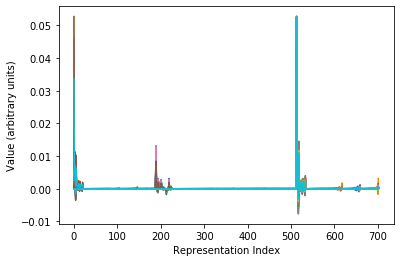

In [20]:
import matplotlib.pyplot as plt
for i in range(50):
    plt.plot(np.arange(len(soap_raw[0])), data.iloc[i])
plt.xlabel('Representation Index')
plt.ylabel('Value (arbitrary units)')
plt.show()

# Data Splitting

In [21]:
shuffled_names = list(entry_names)
np.random.shuffle(shuffled_names)
training_fraction = 0.8
n_train = int(len(df) * training_fraction)
training_names = shuffled_names[:n_train]
testing_names = shuffled_names[n_train:]
training_inputs = data.loc[training_names].values
print(training_inputs.shape)
training_outputs = df.loc[training_names]['Formation Energy']
print(training_outputs.shape)
testing_inputs = data.loc[testing_names].values
print(testing_inputs.shape)
testing_outputs = df.loc[testing_names]['Formation Energy']
print(testing_outputs.shape)

(3738, 702)
(3738,)
(935, 702)
(935,)


# Machine Learning

In [22]:
model = SVR().fit(training_inputs, training_outputs)
testing_predictions = model.predict(testing_inputs)
print(np.sqrt(np.mean(np.subtract(testing_predictions, testing_outputs)**2)))

0.05631257769660664


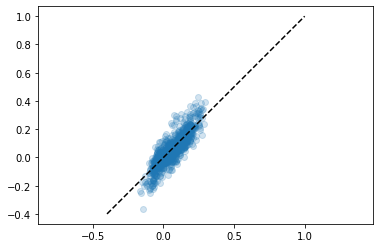

In [23]:
plt.scatter(testing_predictions, testing_outputs, alpha=0.2)
plt.plot([-0.4, 1], [-0.4, 1], 'k--')
plt.axis('equal')
plt.show()
import pickle
pickle.dump(model,open('Cd-Te.sav','wb'))

# Normalizing Representations
Often, it is helpful to normalize the inputs for machine learning. Earlier, we observed that the ranges across different features in the representation can vary dramatically. Here, we normalize all 702 features independently such that they are centered at 0 and have a variance of 1. This is not always necessary, depending on the representation chosen. It does not appear to help with SOAP.

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(training_inputs)
training_inputs = scaler.transform(training_inputs)
testing_inputs = scaler.transform(testing_inputs)
### If we use normalized data representation for the quantumml we will need to store the scaler model

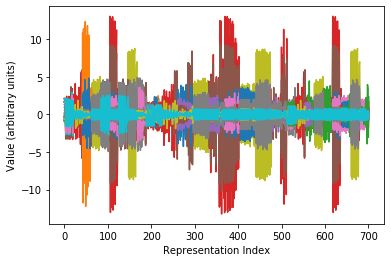

In [28]:
for i in range(50):
    plt.plot(np.arange(len(soap_raw[0])), training_inputs[i])
plt.xlabel('Representation Index')
plt.ylabel('Value (arbitrary units)')
plt.show()

In [29]:
model = SVR().fit(training_inputs, training_outputs)
testing_predictions = model.predict(testing_inputs)
rms = (np.sqrt(np.mean(np.subtract(testing_predictions, testing_outputs)**2)))
print(rms)

0.056242614639686134


Text(0.5, 1.0, 'CdTe')

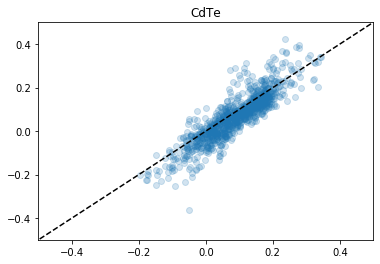

In [30]:
plt.scatter(testing_predictions, testing_outputs, alpha=0.2)
plt.plot([-2, 25], [-2, 25], 'k--')
#plt.axis('equal')
axes = plt.gca()
xmin = -.5
ymin = xmin
xmax = .5
ymax = xmax
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.title('CdTe')

# Random search to select best hyperparameters
Almost every machine learning algorithm is associated with hyperparameters -- parameters that are not optimized by the algorithm itself, like weights. Examples include the choice of and options associated with representations, depth of the neural network, and regularization strength in various solvers. Here, we optimize Gamma and C, which are hyperparameters of support vector regression.

The C parameter trades off misclassification of training examples against simplicity of the model.

Gamma defines an overall scale factor for the support vector machine's notion of distance between two points.

In [34]:
%%time
cScale = 4  # scale for exponential distribution
gScale = 0.01  # scale for exponential distribution
n_iter = 15  # number of iterations for random search. Realistically ~100
    
param_dist = {'C': scipy.stats.expon(scale=cScale), 
              'gamma': scipy.stats.expon(scale=gScale), 
              'kernel': ['rbf']}

# using random search cross validation to select best hyperparameters,
# performing 5-fold cross validation
cv = CV(SVR(), 
        param_distributions=param_dist, 
        cv=5, 
        scoring='neg_mean_squared_error', 
        n_iter=n_iter, 
        n_jobs=n_cores, 
        refit=False) 

search=cv.fit(training_inputs, training_outputs) #trains the model using training set alone

C = search.best_params_['C']
gamma = search.best_params_['gamma']
print(search.best_params_)

{'C': 10.178185975575827, 'gamma': 0.0010725922536294929, 'kernel': 'rbf'}
CPU times: user 1.01 s, sys: 578 ms, total: 1.58 s
Wall time: 1min 35s


In [35]:
model = SVR(C=C, gamma=gamma)
model.fit(training_inputs, training_outputs)
testing_predictions = model.predict(testing_inputs)
rms = (np.sqrt(np.mean(np.subtract(testing_predictions, testing_outputs)**2)))
print(rms)

0.05285696757225154


Text(0.5, 1.0, 'CdTe')

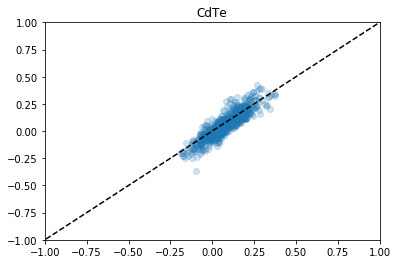

In [36]:
plt.scatter(testing_predictions, testing_outputs, alpha=0.2)
plt.plot([-12, 40], [-12, 40], 'k--')
#plt.axis('equal')
axes = plt.gca()
xmin = -1
ymin = xmin
xmax = 1
ymax = xmax
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.title('CdTe')

# Other feature of quantumml
below I will describe some of the other current features of quantumml

# Queries

This shows an example of how to utilize the MWRester class to access materialsweb calculations
- **band_gap_range**  
Range of bandgaps in *eV* as a two valued list eg. [1.2, 3.1]  
- **Formation_energy_range**  
Range of formation energies in *meV* as two values list eg. [50, 150]
- **elements**  
List of elements contained in entry eg. ['Na', 'Cl']  
note: this will return all entries that contain Na and Cl as well as any other element 
- **space_group_number**  
integer of space group number eg. 5
- **dimention**  
integer of dimension of material eg. 2
- **crystal_system**  
crystal system as a string eg. 'Tetragonal'  


In [45]:
with MWRester() as mwr:
    mwr.get_calculation(space_group_number = 10)
    structure_list = mwr.as_pymatgen_struc()
    for structure in structure_list:
        print(structure) 

Full Formula (Cu1 Te1 O4)
Reduced Formula: CuTeO4
abc   :   2.996064   6.078667  22.548377
angles:  93.195975  90.000000  90.000000
Sites (6)
  #  SP      a         b         c
---  ----  ---  --------  --------
  0  Cu    0    0         0.056509
  1  Te    0.5  0.5       0.056509
  2  O     0.5  0.814202  0.078196
  3  O     0.5  0.185798  0.034822
  4  O     0    0.457734  0.112871
  5  O     0    0.542266  0.000147
Full Formula (La4 C2 Cl5)
Reduced Formula: La4C2Cl5
abc   :   3.979734   7.976692  26.022557
angles:  89.992903  89.999698  89.998247
Sites (11)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  La    0.99999   0.99998   0
  1  La    0.500012  0.213028  0.115718
  2  La    0.499988  0.786972  0.115718
  3  La    1e-05     2e-05     0.231436
  4  C     0.999917  0.999935  0.088386
  5  C     8.3e-05   6.5e-05   0.14305
  6  Cl    0.499996  0.272206  0.002774
  7  Cl    0.49998   0.727766  0.00277
  8  Cl    0         0.5       0.115718
  

In [46]:
help(MWRester.get_calculation)

Help on function get_calculation in module quantumml.rest:

get_calculation(self, band_gap_range=None, formation_energy_range=None, elements=[], space_group_number=None, dimension=None, crystal_system=None, name=None)
    Method to that queries materialsweb database and returns a list of dictionaries of calculations that
    fit the querries parameters. Additionally
    Parameters
    ----------
    band_gap_range : list
    List of band gap range e.g. [min, max]
    formation_energy_range : list
        List of formation energy range e.g. [min, max]
    elements : list
    List of str of elements
    space_group_number : int
        space group number
    dimension : int
        dimension as int e.g. 1 2 3
    crystal_system : str
        name of crystal system
    name : str
        name of material e.g. MoS2
    Returns
    -------
    results : list
        List of results matching query parameters



In [40]:
with MWRester() as mwr:
    mwr.get_calculation(band_gap_range=[1,1.5], formation_energy_range=[124,150])
    for d in mwr.results:
        #print(d.keys())
        if len(d['composition'].split('/')[-2].replace('%',''))< 8:
            print(d['composition'].split('/')[-2].replace('%','')+'\t\t\t BandGap = ' + \
                  str(round(d['band_gap'],4))+' eV\t Formation Eneergy = ' + str(d['formation_energy'])+ ' meV')
        elif len(d['composition'].split('/')[-2].replace('%',''))< 16:
            print(d['composition'].split('/')[-2].replace('%','')+'\t\t BandGap = ' + \
                  str(round(d['band_gap'],4))+' eV\t Formation Eneergy = ' + str(d['formation_energy'])+ ' meV')
        else:
            print(d['composition'].split('/')[-2].replace('%','')+'\t BandGap = ' + \
                  str(round(d['band_gap'],4))+' eV\t Formation Eneergy = ' + str(d['formation_energy'])+ ' meV')
    
    
    print(f'\n Example of Json responce\n {json.dumps(mwr.results[0],sort_keys=True, indent=10)}')


Pd120S2			 BandGap = 1.1746 eV	 Formation Eneergy = 148.0 meV
Ge120Se1		 BandGap = 1.2107 eV	 Formation Eneergy = 133.0 meV
Pd120Se2		 BandGap = 1.3964 eV	 Formation Eneergy = 166.0 meV
I220Pt1			 BandGap = 1.4215 eV	 Formation Eneergy = 135.0 meV
I220Pd1			 BandGap = 1.1512 eV	 Formation Eneergy = 133.0 meV
Br320Cr1		 BandGap = 1.4714 eV	 Formation Eneergy = 742.0 meV
Cr120H120O2		 BandGap = 1.0072 eV	 Formation Eneergy = 179.0 meV
Mo120O3			 BandGap = 1.1381 eV	 Formation Eneergy = 136.0 meV

 Example of Json responce
 {
          "attempt": 0,
          "band_gap": 1.1745999999999999,
          "composition": "http://172.16.170.227:7800/rest/composition/Pd1%20S2/",
          "configuration": null,
          "converged": true,
          "dimension": 2,
          "dos": "http://172.16.170.227:7800/rest/dos/29/",
          "element_set": [
                    "http://172.16.170.227:7800/rest/elements/Pd/",
                    "http://172.16.170.227:7800/rest/elements/S/"
          ],
 

Example of http responce for current calculations

In [31]:
!http https://materialsweb.org/rest/calculation/28/

HTTP/1.1 200 OK
Allow: GET
Connection: close
Content-Encoding: gzip
Content-Length: 614
Content-Type: application/json
Date: Fri, 12 Feb 2021 20:12:00 GMT
Server: Apache
Vary: Accept,Cookie,Accept-Encoding
Via: 1.1 materialsweb.org


{
    "attempt": 0,
    "band_gap": 1.1745999999999999,
    "composition": "http://172.16.170.227:7800/rest/composition/Pd1%20S2/",
    "configuration": null,
    "converged": true,
    "dimension": 2,
    "dos": "http://172.16.170.227:7800/rest/dos/29/",
    "element_set": [
        "http://172.16.170.227:7800/rest/elements/Pd/",
        "http://172.16.170.227:7800/rest/elements/S/"
    ],
    "energy": -22.07599683,
    "energy_pa": -3.679332805,
    "entry": "http://172.16.170.227:7800/rest/entry/30/",
    "formation_energy": 148.0,
    "input": "http://172.16.170.227:7800/rest/structure/86/",
    "irreducible_kpoints": 25.0,
    "is_direct": false,
    "label": "mp-13682",
    "magmom": -6.99e-05,
    "magmom_pa": -1.165e-05,
    "natoms": 6,
    "nste

# Write files
This Portion is not complete

In [43]:
help(MWRester().write)
#help(mwr.write_all)

Help on method write in module quantumml.rest:

write(index=0) method of quantumml.rest.MWRester instance
    Writes INCAR, KPOINTS, POSCAR of entry to current directory
    
    Parameters
    ----------
    index : int
        Index of entry to write files for
    todo: add unit test



In [ ]:
import os 
os.mkdir('example')
%cd example
mwr.write_all()
%ls
%cd ..

In [ ]:
%cd ~/dev/quantumML
%pwd

In [ ]:
#Convert to list of pymatgen structures
print(help(mwr.as_pymatgen_struc()))
c = mwr.as_pymatgen_struc()